In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import random as rand


In [1]:
print("just work")

just work


## CTU13 Dataset preparation
(dataloaders for train/test ; encoding ect)

In [3]:
data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")

/tmp/ipykernel_36/3032590272.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/kaggle/input/ctu-13/CTU_13.csv")


In [4]:
le = LabelEncoder()


In [5]:
lst = []
for i in data['Label']:
        if 'Botnet' in i:
            lst.append(1)
        elif 'Normal' in i:
            lst.append(2)
        else:
            lst.append(0)
data['Label']=lst

In [40]:

data=data[data['Label']!=0]
direction_number = []
for i in data['Dir']:
        if i == '  <->':
            direction_number.append(1)
        elif i == '   ->':
            direction_number.append(2)
        else:
            direction_number.append(0)
data['Dir'] = direction_number
dataset=data.drop(columns=['Unnamed: 0'],inplace=False)
dataset.dropna(inplace=True)
dt = pd.to_datetime(dataset['StartTime'], format='%Y/%m/%d %H:%M:%S.%f')
df = pd.DataFrame({'datetime': dt})
dataset['year'] = df['datetime'].dt.year
dataset['month'] = df['datetime'].dt.month
dataset['day'] = df['datetime'].dt.day
dataset['hour'] = df['datetime'].dt.hour
dataset['minute'] = df['datetime'].dt.minute
dataset['second'] = df['datetime'].dt.second
dataset['dayofweek'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
dataset['is_weekend'] = dataset['dayofweek'].isin([5,6]).astype(int)
dataset.drop(columns=['StartTime'],inplace=True)
#fixed sprint2 added the packetlength column
dataset['packet_length'] = dataset['TotBytes'] / dataset['TotPkts']
cat_cols=['Proto','SrcAddr','DstAddr','Dport','State']
for col in cat_cols:
        numeric_labels = le.fit_transform(dataset[col])
        dataset[col]=numeric_labels
numeric_labels = le.fit_transform(dataset['Sport'].astype('str'))
dataset['Sport']=numeric_labels
total_len = len(dataset)
datasetlabeled=dataset.copy()
dataset.drop(columns=['Label'],inplace=True)
# 80% for encoder (unlabeled)
encoder_data = dataset[:int(total_len * 0.8)]
# Next 10% for linear classifier training (labeled)
lineardata = datasetlabeled[int(total_len * 0.8):int(total_len * 0.9)]
# Final 10% for evaluation (labeled)
datasetevaluation = datasetlabeled[int(total_len * 0.9):]



when you have no labels  , what do you do to deal with that? what is the best approach to transform the data with no labels so when it is passed to whatever
classifier you are using it gives the best accurancy , for this i would have a random forest classifier pretraind , then try different approaches under the hood of unsupervised /supervised learning then see which gives the best results with the pretrained random forest classifier 

## Initial result with random forest without any intervention : Baseline features

In [7]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)


In [8]:
lineardata_y=lineardata['Label']
lineardata_x=lineardata.drop(columns=['Label'],inplace=False)


In [9]:
classifier.fit(lineardata_x,lineardata_y)

RandomForestClassifier(random_state=42)

### evaluation of initial rf

In [10]:
datasetevaluation_y=datasetevaluation['Label']
datasetevaluation_x=datasetevaluation.drop(columns=['Label'],inplace=False)

In [11]:
y_pred=classifier.predict(datasetevaluation_x)

In [12]:
accuracy = accuracy_score(datasetevaluation_y, y_pred)
print(f"Baseline Accuracy: {accuracy*100:.2f}%")



Baseline Accuracy: 99.43%


In [13]:
precision = precision_score(datasetevaluation_y, y_pred, average="binary")  
recall = recall_score(datasetevaluation_y, y_pred, average="binary")
f1 = f1_score(datasetevaluation_y, y_pred, average="binary")

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

Precision: 1.00, Recall: 0.99, F1: 0.99


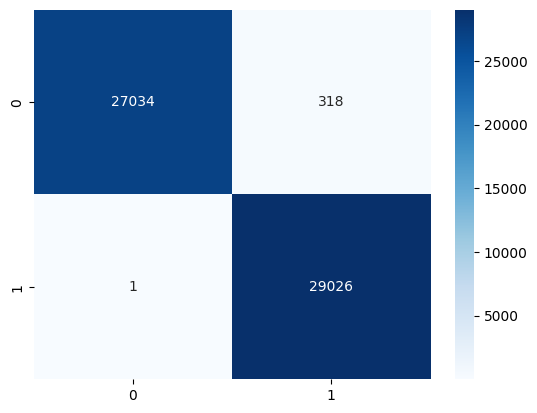

In [14]:
cm = confusion_matrix(datasetevaluation_y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [15]:
#ROC-AUC / PR-AUC
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(datasetevaluation_y, classifier.predict_proba(datasetevaluation_x)[:,1])
print(f"ROC-AUC: {auc:.2f}")

ROC-AUC: 1.00


### #to do : test on more datasets (bigger/different cause those metrics results are stupid )

## Module 1 — Unlabeled data
Goal: produce useful representations or anomaly scores without using labels during training.


## Noise

here we just go throught the typocal process of dataset cleaning
but here we aren not just talking about typocal noise cleaning , we want later on when we are using this system the model should have some smart way to deal with missing data 

i want the tasks of noise reduction/feature selection/encoding and pattern reenforcment to be done in the architecture we weill create not the steps we do manually , ma no93odech nvisualizy fel 3ze w nkasar fi rasssi 

it is really important the noise we are creating is as realistic as possible, cause it impacts the quality of performacne of the dae later , the usual noise we find in cybersecurity datasets is


In [41]:
def noisify(data):
    data = data.copy()
    np.random.seed(42)

    # Random packet loss or dropped features
    nb_features = len(data.columns)
    num_drops = rand.randint(1, 3)

    # the indexes to the random drops
    drop_indices = np.random.randint(0, nb_features, size=(len(data), num_drops))

    # cool way to do it
    rows = np.repeat(np.arange(len(data)), num_drops)
    cols = drop_indices.flatten()
    data.values[rows, cols] = np.nan  # when i do nan it gets me erro later , until i figure out how
                                # not have to deal with that and fix the masked loss function IT IS STAYING 0000

    # Swapping Source/Destination IPs
    # fixed sprint2 no changing column places
    # Randomly pick 10% of rows to swap
    mask = np.random.rand(len(data)) < 0.1
    data.loc[mask, ['SrcAddr', 'DstAddr']] = data.loc[mask, ['DstAddr', 'SrcAddr']].values

    # Changing Protocol Numbers (TCP → UDP)
    protocol_map = {6: 17, 17: 6}  # TCP <-> UDP
    # Apply noise to 5-10% of rows
    mask = np.random.rand(len(data)) < 0.05
    data.loc[mask, 'Proto'] = data.loc[mask, 'Proto'].map(lambda x: protocol_map.get(x, x))

    # Slightly Modifying Packet Lengths or Time Intervals
    # fixed sprint2 those tow lignes are useless
    # data['packet_length'] = data['TotBytes'] / data['TotPkts']
    # data['packet_length'].replace(np.nan,0)
    noise_fraction = 0.05
    mask = np.random.rand(len(data)) < 0.1  # apply to 10% of rows
    # data['packet_length'] = data['TotBytes'] / data['TotPkts']
    data.loc[mask, 'packet_length'] = data.loc[mask, 'packet_length'] * (
        1 + np.random.uniform(-noise_fraction, noise_fraction, mask.sum())
    )

    # Modify timestamps by a small jitter
    # to fix see if keep adjusted time per second only or more
    # just in seconds cause minute +- is too much
    time_jitter = 2  # seconds
    mask = np.random.rand(len(data)) < 0.1
    data.loc[mask, 'second'] = data.loc[mask, 'second'] + np.random.uniform(
        -time_jitter, time_jitter, mask.sum()
    )

    # feature level noise
    row_noise_fraction = 0.1  # 10%
    # Standard deviation as a fraction of the original value
    std_fraction = 0.05  # ±5%
    for col in data.columns:
        mask = np.random.rand(len(data)) < row_noise_fraction
        noise = data.loc[mask, col] * np.random.normal(0, std_fraction, mask.sum())
        data.loc[mask, col] = data.loc[mask, col] + noise

    return data


In [35]:
print(f"encoder data {list(encoder_data.columns)} : {len(list(encoder_data.columns))}")
print(f"------------------------------")
print(f"noise data {list(noisify(encoder_data).columns)}   : {len(list(noisify(encoder_data).columns))}")


encoder data ['Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'is_weekend', 'packet_length'] : 22
------------------------------
noise data ['Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos', 'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'is_weekend', 'src_ip_noisy', 'dst_ip_noisy', 'protocol_noisy', 'packet_length_noisy', 'timestamp_noisy', 'SrcBytes_noisy', 'TotPkts_noisy', 'TotBytes_noisy', 'Dur_noisy']   : 23


## sprint 2: review : issues with noisify
### columns names mismatch
the columns has to keep the same order , when you pass it later we compare column 1 of encoderdata with column 1 of traindata
(compare in training )
so fix one must do the changes while keeping the order 


## Autoencoder (Denoising AE or Variational AE)

An autoencoder is a neural network trained to reconstruct its input.
It has two parts:

Encoder → compresses input into a low-dimensional latent representation.

Decoder → reconstructs the input from that latent representation.

By training it on "clean" or "normal" data, it learns the underlying signal and ignores irrelevant patterns.

### Denoising Autoencoder (DAE)

In [37]:
print("test")

test


In [42]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # assuming features normalized [0,1]
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out 

probelm with DAE , the power of DAE is that it rely on the noisy data it was trained on to be able to differ it from the real data that way it caputres the pattern , but if it is introduced to new noise it would mess it up and not be able to create the right representation of the data

In [19]:
encoder_data.columns

Index(['Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State',
       'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'year', 'month',
       'day', 'hour', 'minute', 'second', 'dayofweek', 'is_weekend',
       'packet_length'],
      dtype='object')

In [43]:
train_encoder=noisify(encoder_data)

/tmp/ipykernel_36/654791944.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[52.01484064  9.37415346 11.72353414 ... 48.74999296 46.49784987
 46.10575137]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[mask, 'second'] = data.loc[mask, 'second'] + np.random.uniform(
/tmp/ipykernel_36/654791944.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.1173492  3.13670515 3.17411488 ... 2.87655755 3.03982492 3.24263893]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, col] = data.loc[mask, col] + noise
/tmp/ipykernel_36/654791944.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[   1.91011163    2.14716785    6.40225483 ...   17.60

In [44]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

encoder_data = scaler.fit_transform(encoder_data)
train_encoder = scaler.transform(train_encoder)


In [141]:
encoder_data

tensor([[2.9100e-04, 3.0000e+00, 2.0000e+00,  ..., 5.4000e+01, 2.0000e+00,
         0.0000e+00],
        [3.2100e-04, 3.0000e+00, 2.0000e+00,  ..., 5.4000e+01, 2.0000e+00,
         0.0000e+00],
        [7.6780e-03, 2.0000e+00, 2.0000e+00,  ..., 5.4000e+01, 2.0000e+00,
         0.0000e+00],
        ...,
        [1.4035e-01, 3.0000e+00, 1.0000e+01,  ..., 4.7000e+01, 2.0000e+00,
         0.0000e+00],
        [1.2433e+02, 2.0000e+00, 7.0000e+00,  ..., 4.7000e+01, 2.0000e+00,
         0.0000e+00],
        [1.1275e-01, 3.0000e+00, 1.7000e+01,  ..., 4.7000e+01, 2.0000e+00,
         0.0000e+00]])

### training 

In [146]:
"""train_encoder=train_encoder.drop(columns=['timestamp_noisy'])
train_encoder = train_encoder.select_dtypes(include=[np.number])

# Replace NaN and Inf
train_encoder = train_encoder.replace([np.inf, -np.inf], 0).fillna(0)

encoder_data = encoder_data.select_dtypes(include=[np.number])
encoder_data = encoder_data.replace([np.inf, -np.inf], 0).fillna(0)

# Now safely convert
train_encoder = torch.tensor(train_encoder.values, dtype=torch.float32)
encoder_data = torch.tensor(encoder_data.values, dtype=torch.float32)"""

In [45]:

train_encoder = torch.tensor(train_encoder, dtype=torch.float32)
encoder_data = torch.tensor(encoder_data, dtype=torch.float32)

dataset = TensorDataset(encoder_data, train_encoder)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [46]:
#the nan issue is fiwed by 
def masked_mse_loss(pred, target):
    mask = ~torch.isnan(target)
    return ((pred - target)[mask] ** 2).mean()

In [47]:
print(train_encoder.shape,encoder_data.shape)

torch.Size([451032, 22]) torch.Size([451032, 22])


In [48]:
print(torch.isnan(train_encoder).sum())


tensor(0)


In [49]:
model=DenoisingAutoencoder(22)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [50]:
epochs = 20


In [51]:
for epoch in range(epochs):
    for noisy_batch, clean_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(noisy_batch)
        loss = masked_mse_loss(outputs, clean_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 36.5265
Epoch [2/20], Loss: 49.0091
Epoch [3/20], Loss: 14.3718
Epoch [4/20], Loss: 33.1526
Epoch [5/20], Loss: 60.1080
Epoch [6/20], Loss: 6.3721
Epoch [7/20], Loss: 35.1282
Epoch [8/20], Loss: 35.8935
Epoch [9/20], Loss: 50.1816
Epoch [10/20], Loss: 35.1982
Epoch [11/20], Loss: 7.6234
Epoch [12/20], Loss: 87.1463
Epoch [13/20], Loss: 214.1165
Epoch [14/20], Loss: 81.3599
Epoch [15/20], Loss: 19.2995
Epoch [16/20], Loss: 31.4989
Epoch [17/20], Loss: 148.4150
Epoch [18/20], Loss: 105.5389
Epoch [19/20], Loss: 190.9492
Epoch [20/20], Loss: 196.8450


In [85]:
X_labeled = lineardata.drop(columns=['Label']).select_dtypes(include=[np.number])
y_labels = lineardata['Label']

# Map labels to 0..N-1
unique_labels = np.unique(y_labels)
label_map = {old: new for new, old in enumerate(unique_labels)}
y_labels = y_labels.map(label_map)

# Convert to tensor
X_tensor = torch.tensor(X_labeled.values, dtype=torch.float32).to(device)

# Get embeddings from encoder
model.eval()
with torch.no_grad():
    embeddings = model.encoder(X_tensor).cpu().numpy()

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(embeddings, y_labels)

RandomForestClassifier(random_state=42)

In [88]:
X_eval = datasetevaluation.drop(columns=['Label']).select_dtypes(include=[np.number])
y_eval = datasetevaluation['Label'].map(label_map)

X_eval_tensor = torch.tensor(X_eval.values, dtype=torch.float32).to(device)

with torch.no_grad():
    eval_embeddings = model.encoder(X_eval_tensor).cpu().numpy()


In [89]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf.predict(eval_embeddings)

print("Accuracy:", accuracy_score(y_eval, y_pred))
print("Classification Report:\n", classification_report(y_eval, y_pred))


Accuracy: 0.9410241401940439
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     27352
           1       0.92      0.97      0.94     29027

    accuracy                           0.94     56379
   macro avg       0.94      0.94      0.94     56379
weighted avg       0.94      0.94      0.94     56379

